In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as sopt
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder

In [2]:
data1 = sio.loadmat("exp4data1.mat")
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
raw_X = data1["X"]  # 原始数据
raw_y = data1["y"]
raw_X.shape, raw_y.shape

((5000, 400), (5000, 1))

## 数据可视化

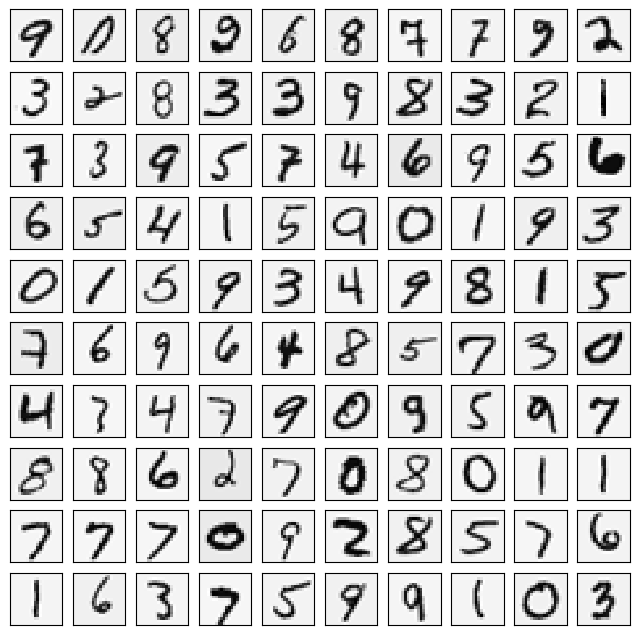

In [4]:
idx = np.random.choice(range(5000), 100)
imgs = raw_X[idx]
fig, ax = plt.subplots(10, 10, figsize=(8, 8), sharex=True, sharey=True)
for r in range(10):
    for c in range(10):
        ax[r, c].matshow(imgs[r*10+c].reshape(20, 20).T, cmap="gray_r")
plt.xticks([])
plt.yticks([])
plt.show()

## 数据处理

In [5]:
X = np.insert(raw_X, 0, 1, axis=1)  # 加入偏置

# One_Hot 编码
result = []
for i in raw_y:
    y_tmp = np.zeros(10)
    y_tmp[i-1] = 1
    result.append(y_tmp)
y = np.array(result)      # One-Hot编码后

In [6]:
X.shape, y.shape

((5000, 401), (5000, 10))

## 权重参数

In [7]:
data2 = sio.loadmat("exp4data2.mat")  # 原始权重参数
theta1 = data2["Theta1"]
theta2 = data2["Theta2"]
theta1.shape, theta2.shape

((25, 401), (10, 26))

## 序列化

In [8]:
def serialize(a, b):
    return np.r_[a.flatten(), b.flatten()]

def deserialize(seq):
    return seq[:25*401].reshape(25, 401), seq[25*401:].reshape(10, 26)

theta = serialize(theta1, theta2)

In [9]:
theta.shape

(10285,)

## 前向传播

In [10]:
def sigmod(z):
    return 1 / (1 + np.exp(-z))

In [11]:
def feedForward(theta, X):
    """前向传播"""
    theta1, theta2 = deserialize(theta)
    a1 = X
    z2 = a1 @ theta1.T
    a2 = np.insert(sigmod(z2), 0, 1, axis=1)
    z3 = a2 @ theta2.T
    a3 = sigmod(z3)     # 预测结果h

    return a1, z2, a2, z3, a3

In [12]:
a1, z2, a2, z3, h = feedForward(theta, X)
y_predict = np.argmax(h, axis=1) + 1
acc = np.mean(y_predict==raw_y)
print("accuracy = {}%".format(acc * 100))

accuracy = 10.0%


## 损失函数

并不重要
$$
J(\theta) = \dfrac{1}{m}\sum_{i=1}^m\sum_{k=1}^K[-y_k^{(i)}\log((h_{\theta}(x^{(i)}))_k)-(1-y_k^{(i)})\log(1-(h\theta(x^{(i)}))_k)] 
$$

In [13]:
def costFunc(theta, X, y):
    _, _, _, _, h = feedForward(theta, X)
    J = -y * np.log(h) - (1 - y) * np.log(1 - h)
    return J.sum() / len(X)

In [14]:
costFunc(theta, X, y)

0.2876291651613189

## 损失函数正则化

$$
J(\theta) = \dfrac{1}{m}\sum_{i=1}^m\sum_{k=1}^K[-y_k^{(i)}\log((h_{\theta}(x^{(i)}))_k)-(1-y_k^{(i)})\log(1-(h\theta(x^{(i)}))_k)] + \dfrac{\lambda}{2m}[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2]
$$

In [15]:
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [16]:
def regularizedCostFunc(theta, X, y, l=1):
    """正则时忽略每层的偏置（截距），即参数矩阵的第一列"""
    reg = np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:, 1:], 2))
    return l / (2 * len(X)) * reg + costFunc(theta, X, y)

In [17]:
regularizedCostFunc(theta, X, y, 1)

0.38376985909092365

## 反向传播

$$ f'(x) = \frac{e^{-x}}{(1 + e^{-x})^2} $$

In [18]:
def sigmodGradient(z):
    return sigmod(z) * (1 - sigmod(z))

In [19]:
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [20]:
def gradient(theta, X, y):
    theta1, theta2 = deserialize(theta)
    a1, z2, a2, z3, h = feedForward(theta, X)
    d3 = h - y
    d2 = d3 @ theta2[:, 1:] * sigmodGradient(z2)
    D2 = (d3.T @ a2) / len(X)
    D1 = (d2.T @ a1) / len(X)

    return serialize(D1, D2)

In [21]:
def regularizeGradient(theta, X, y, l):
    D = gradient(theta, X, y)
    D1, D2 = deserialize(D)

    theta1, theta2 = deserialize(theta)
    D1[:, 1:] = D1[:, 1:] + theta1[:, 1:] * l / len(X)
    D2[:, 1:] = D2[:, 1:] + theta2[:, 1:] * l / len(X)

    return serialize(D1, D2)

In [22]:
# 随机初始化参数，在(-a, a)中选择
def randomInit(size):
    return np.random.uniform(-0.5, 0.5, size)

def nnTraining(X, y):
    init_theta = randomInit(len(theta))
    result = sopt.minimize(fun=regularizedCostFunc, 
                           x0=init_theta, 
                           args=(X, y, l), 
                           method="TNC", 
                           jac=regularizeGradient)

    return result

In [23]:
l = 10
result = nnTraining(X, y)

In [24]:
result

 message: Linear search failed
 success: False
  status: 4
     fun: 1.5174759689807558
       x: [ 9.371e-01  9.255e-04 ...  1.325e+00 -1.149e+00]
     nit: 17
     jac: [-2.947e-04  1.851e-06 ...  6.734e-04  2.102e-04]
    nfev: 323

In [25]:
raw_y = data1["y"].reshape(5000,)
_, _, _, _, h = feedForward(result.x, X)
y_predict = np.argmax(h, axis=1) + 1
acc = np.mean(y_predict == raw_y)

print("accuracy = {}%".format(acc * 100))

accuracy = 94.19999999999999%


## 隐藏层

In [26]:
def plotHiddenLayer(theta):
    theta1, _ = deserialize(theta)
    hidden_layer = theta1[:, 1:]
    fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(8, 8), sharex=True, sharey=True)

    for r in range(5):
        for c in range(5):
            ax[r, c].matshow(hidden_layer[r*5+c].reshape(20, 20).T, cmap="gray_r")

    plt.xticks([])
    plt.yticks([])
    
    plt.show()

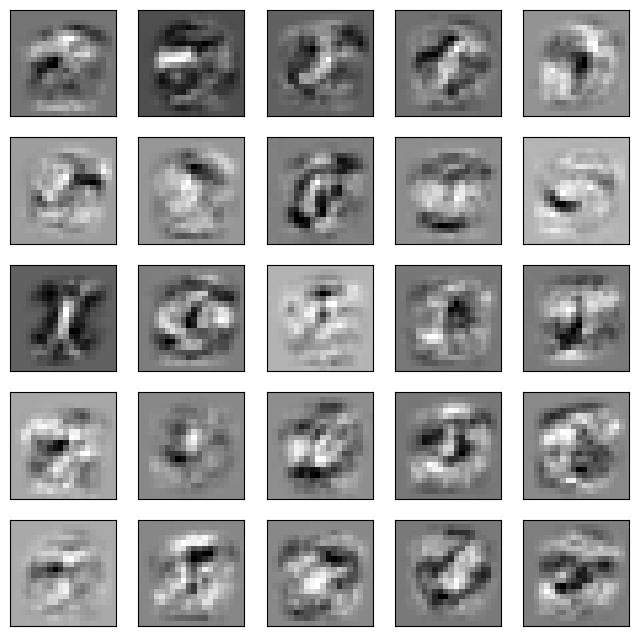

In [27]:
plotHiddenLayer(result.x)